### 시황을 고려한 투자의 중요성
- 증시를 경제 사이클에 따라 분류
- 각 시황별 주식, 채권, 원자재, 달러의 대표 지수의 성과지표를 비교분석해본다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
import time

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import yfinance as yf
from fredapi import Fred

import sys
sys.path.append("/Users/jtchoi/Library/CloudStorage/GoogleDrive-jungtaek0227@gmail.com/My Drive/quant/Quant-Project/quant")
from backtest.metric import *
from econ_regime.econ_regime import *

### 데이터 로드

In [2]:
sp500 = yf.download('SPY')['Adj Close']
sp500.index = pd.to_datetime(pd.to_datetime(sp500.index).date)
sp500 = sp500.resample('M').last()
sp500 = sp500.iloc[:-2]

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500

1993-01-31     25.218222
1993-02-28     25.487267
1993-03-31     26.058167
1993-04-30     25.391388
1993-05-31     26.076183
                 ...    
2022-08-31    391.764313
2022-09-30    355.547302
2022-10-31    384.444611
2022-11-30    405.816467
2022-12-31    382.429993
Freq: M, Name: Adj Close, Length: 360, dtype: float64

### 미국경제를 디플레이션, 인플레이션, 회복기, 확장기로 분류

    - 정의:
      - OECD 미국 경기선행지수: 장단기금리차, 종합주가지수, 제조업 업황지수, 제조업 주간노동시간, 소비자신뢰지수, 내구재 신규주문, 주택착공건수
      - OECD 경기선행지수 100pt를 기준으로 고성장과 저성장으로 나눔
      - OECD 경기선행지수를 바탕으로 성장 상승 및 하락 추세 반영
      - Core PCE 물가지수 2.5%를 기준으로 고인플레이션과 저인플레이션으로 나눔

    - 국면:
      - deflation: 저성장/성장 하락 추세/저인플레이션
      - inflation: 저성장/성장 하락 추세/고인플레이션
      - recovery: 저성장/성장 상승 추세/저인플레이션, 저성장/성장 상승 추세/고인플레이션
      - expansion: 고성장/성장 상승 추세/고인플레이션, 고성장/성장 하락 추세/고인플레이션

In [4]:
regime_df = business_cycle()
regime_df

,deflation,inflation,recovery,expansion
1994-01-01,0,0,0,1
1994-02-01,0,0,0,1
1994-03-01,0,0,0,1
1994-04-01,0,0,0,1
1994-05-01,0,0,0,1
...,...,...,...,...
2022-08-01,0,1,0,0
2022-09-01,0,1,0,0
2022-10-01,0,1,0,0
2022-11-01,0,1,0,0


In [5]:
regime_df.index = sp500.loc['1994':].index
regime_df = pd.concat([sp500.pct_change(), regime_df], axis=1).dropna()
regime_df.columns = ['sp500_rets', 'deflation', 'inflation', 'recovery', 'expansion']
regime_df

,sp500_rets,deflation,inflation,recovery,expansion
1994-01-31,0.034877,0.0,0.0,0.0,1.0
1994-02-28,-0.029164,0.0,0.0,0.0,1.0
1994-03-31,-0.041901,0.0,0.0,0.0,1.0
1994-04-30,0.011212,0.0,0.0,0.0,1.0
1994-05-31,0.015939,0.0,0.0,0.0,1.0
...,...,...,...,...,...
2022-08-31,-0.040802,0.0,1.0,0.0,0.0
2022-09-30,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.0,1.0,0.0,0.0


### 국면별 sp500 index의 성과지표를 확인
    - 1. sp500에 그대로 투자한 경우
    - 2. sp500에 국면을 반영한 투자의 성과지표들

### sp500 w/o market regime 

<AxesSubplot: title={'center': 'S&P 500'}>

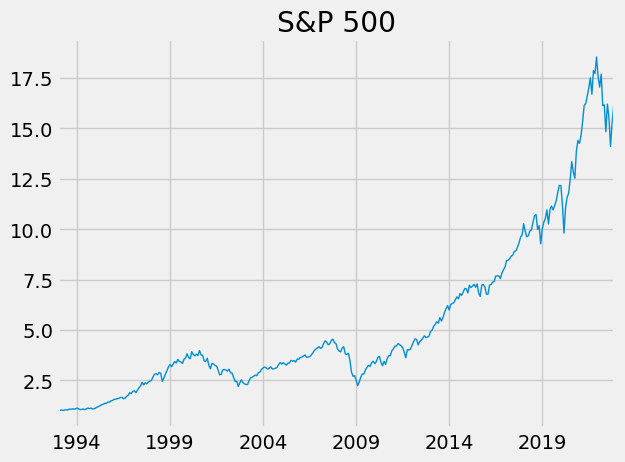

In [6]:
(1 + sp500.pct_change()).cumprod().plot(title='S&P 500', lw=1)

In [7]:
Metric(portfolio=(1 + sp500.pct_change()).cumprod(), freq='month').print_report()

Annualized Return: 9.45%
Annualized Volatility: 14.94%
Skewness: -0.58
Kurtosis: 0.99
Max Drawdown: -50.78%
Max Drawdown Duration: 2252 days
Annualized Sharp Ratio: 0.36
Annualized Sortino Ratio: -0.24
Annualized Calmar Ratio: 0.19
Annualized VaR: -0.11
Annualized VaR Ratio: 0.08
Annualized CVaR: -0.13
Annualized CVaR Ratio: 0.06
Annualized hit Ratio: 0.65
Annualized GtP Ratio: 0.90


### sp500 with market regime

In [6]:
### 계산 방법에 대한 설명 
### 스토리 진행에 대한 간단한 힌트를 제공해서 청취자의 이해를 돕는다. -> 두괄식으로 내용을 설명하고, 이해를 돕는다.
### 성과지표를 테이블로 보여준다. -> 테이블을 보여주고, 이해를 돕는다.
### 인덱스는 성과지표 개수, 컬럼은 5개(시황 + 아무것도 안했을 때)

### sp500 with deflation

<AxesSubplot: >

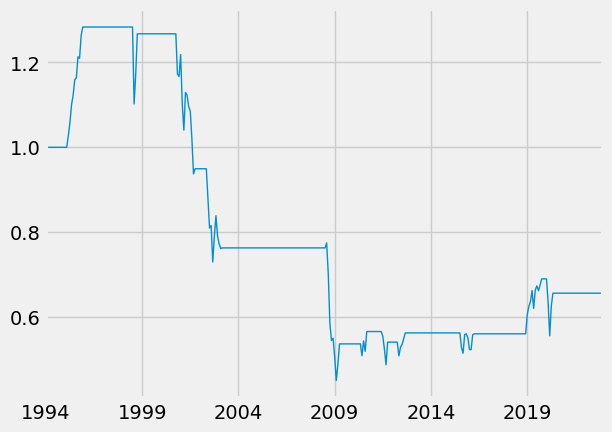

In [8]:
(1 + regime_df.sp500_rets * regime_df.deflation).cumprod().plot(lw=1)

In [9]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.deflation).cumprod(), freq='month').print_report()

Annualized Return: -1.44%
Annualized Volatility: 10.42%
Skewness: -0.79
Kurtosis: 8.18
Max Drawdown: -64.85%
Max Drawdown Duration: 8919 days
Annualized Sharp Ratio: -0.52
Annualized Sortino Ratio: -0.40
Annualized Calmar Ratio: -0.02
Annualized VaR: -0.11
Annualized VaR Ratio: -0.01
Annualized CVaR: -0.13
Annualized CVaR Ratio: -0.01
Annualized hit Ratio: 0.53
Annualized GtP Ratio: 0.78


### sp500 with inflation

<AxesSubplot: >

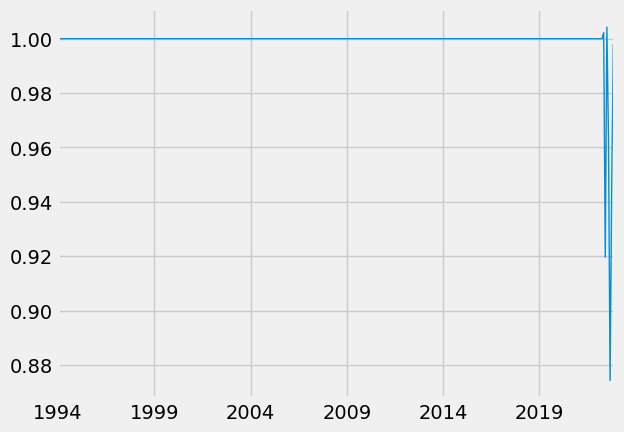

In [10]:
(1 + regime_df.sp500_rets * regime_df.inflation).cumprod().plot(lw=1)

In [11]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.inflation).cumprod(), freq='month').print_report()

Annualized Return: -0.21%
Annualized Volatility: 3.65%
Skewness: -0.26
Kurtosis: 58.43
Max Drawdown: -12.95%
Max Drawdown Duration: 153 days
Annualized Sharp Ratio: -1.15
Annualized Sortino Ratio: -1.14
Annualized Calmar Ratio: -0.02
Annualized VaR: -0.02
Annualized VaR Ratio: -0.01
Annualized CVaR: -0.07
Annualized CVaR Ratio: -0.00
Annualized hit Ratio: 0.50
Annualized GtP Ratio: 0.85


### sp500 with recovery

<AxesSubplot: >

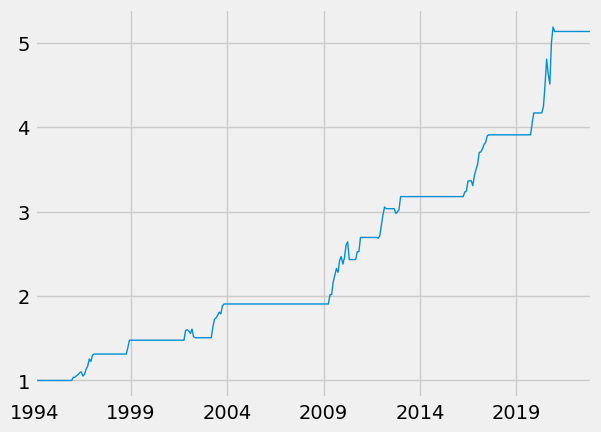

In [12]:
(1 + regime_df.sp500_rets * regime_df.recovery).cumprod().plot(lw=1)

In [13]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.recovery).cumprod(), freq='month').print_report()

Annualized Return: 5.80%
Annualized Volatility: 6.40%
Skewness: 1.91
Kurtosis: 8.40
Max Drawdown: -7.95%
Max Drawdown Duration: 730 days
Annualized Sharp Ratio: 0.28
Annualized Sortino Ratio: -1.19
Annualized Calmar Ratio: 0.73
Annualized VaR: -0.04
Annualized VaR Ratio: 0.13
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.09
Annualized hit Ratio: 0.78
Annualized GtP Ratio: 1.40


### sp500 with expansion

<AxesSubplot: >

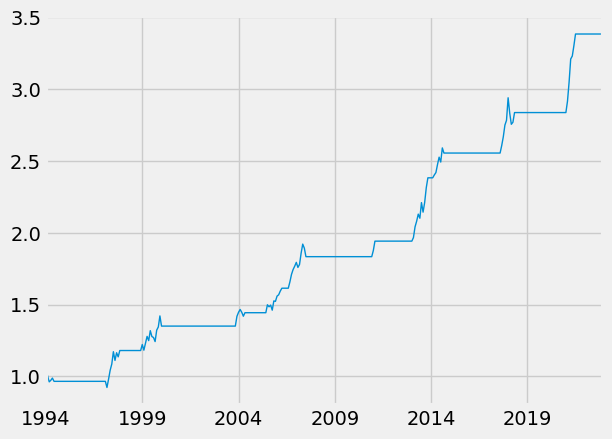

In [14]:
(1 + regime_df.sp500_rets * regime_df.expansion).cumprod().plot(lw=1)

In [15]:
Metric(portfolio=(1 + regime_df.sp500_rets * regime_df.expansion).cumprod(), freq='month').print_report()

Annualized Return: 4.17%
Annualized Volatility: 5.61%
Skewness: 1.28
Kurtosis: 4.93
Max Drawdown: -10.75%
Max Drawdown Duration: 1461 days
Annualized Sharp Ratio: 0.03
Annualized Sortino Ratio: -1.13
Annualized Calmar Ratio: 0.39
Annualized VaR: -0.04
Annualized VaR Ratio: 0.09
Annualized CVaR: -0.05
Annualized CVaR Ratio: 0.08
Annualized hit Ratio: 0.71
Annualized GtP Ratio: 1.20


- 시황 적용의 필요성 인지
- recovery인 경우 가장 성과지표가 좋았다.
- 각 국면 별 투자성과가 좋은 자산군을 찾아보자.

### 자산군
    - 주식: sp500 index
    - 장기채권: TLT ETF
    - 원자재: GSG ETF(tracking S&P GSCI index)
    - 달러: UUP index
    - 부동산: VNQ ETF


In [16]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

In [17]:
asset_ticker = ['SPY','TLT', 'GSG', 'VNQ', 'UUP']
asset_df = asset_indicators(asset_ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
asset_df = asset_df.loc['2008-01-01':,:].dropna().resample('M').last()

In [19]:
asset_df

,SPY,TLT,GSG,VNQ,UUP
2008-01-31,102.328529,62.151608,52.500000,32.629059,22.365517
2008-02-29,99.684105,61.868626,58.410000,31.590994,21.897980
2008-03-31,98.792694,63.191891,57.860001,33.639759,21.373192
2008-04-30,103.501419,61.620773,62.599998,35.785728,21.573565
2008-05-31,105.065941,59.964218,67.900002,35.710232,21.668980
...,...,...,...,...,...
2022-10-31,384.444611,95.170647,21.850000,81.823532,29.767994
2022-11-30,405.816467,101.976341,21.590000,86.852455,28.360384
2022-12-31,382.429993,99.304520,21.230000,82.480003,27.809999
2023-01-31,406.480011,106.894997,21.209999,91.059998,27.510000


In [20]:
ma_regime_df = pd.merge(asset_df.pct_change(), regime_df, left_index=True, right_index=True, how='left').dropna()
ma_regime_df

multi_asset_tickers = ['SPY', 'TLT', 'GSG', 'VNQ', 'UUP']

### 회복국면

<AxesSubplot: >

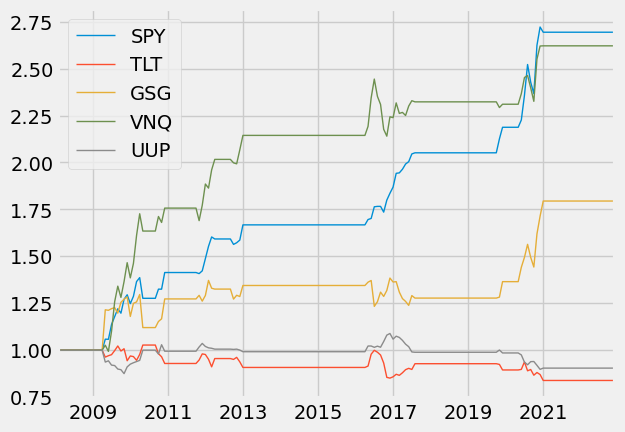

In [21]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['recovery'], axis=0)).cumprod().plot(lw=1)

In [22]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.recovery).cumprod(), freq='month').print_report()
    print()

SPY
Annualized Return: 6.87%
Annualized Volatility: 6.84%
Skewness: 1.62
Kurtosis: 7.63
Max Drawdown: -7.95%
Max Drawdown Duration: 730 days
Annualized Sharp Ratio: 0.42
Annualized Sortino Ratio: -1.06
Annualized Calmar Ratio: 0.86
Annualized VaR: -0.04
Annualized VaR Ratio: 0.16
Annualized CVaR: -0.06
Annualized CVaR Ratio: 0.10
Annualized hit Ratio: 0.78
Annualized GtP Ratio: 1.39

TLT
Annualized Return: -1.17%
Annualized Volatility: 5.75%
Skewness: -0.64
Kurtosis: 7.10
Max Drawdown: -18.37%
Max Drawdown Duration: 4475 days
Annualized Sharp Ratio: -0.90
Annualized Sortino Ratio: -0.72
Annualized Calmar Ratio: -0.06
Annualized VaR: -0.05
Annualized VaR Ratio: -0.02
Annualized CVaR: -0.07
Annualized CVaR Ratio: -0.01
Annualized hit Ratio: 0.48
Annualized GtP Ratio: 0.85

GSG
Annualized Return: 4.00%
Annualized Volatility: 10.10%
Skewness: 1.92
Kurtosis: 20.24
Max Drawdown: -13.60%
Max Drawdown Duration: 1736 days
Annualized Sharp Ratio: -0.00
Annualized Sortino Ratio: -0.52
Annualized 

### 결과
     - recovery: 저성장/성장 상승 추세/저인플레이션, 저성장/성장 상승 추세/고인플레이션
     - 경제가 회복하는 국면
     - 주식과 부동산 등 위험자산이 가장 좋은 성과를 보임
     - 경제와 인플레이션이 점차 회복되어 채권금리가 상승 -> 장기채권은 불리
     - 저성장 -> 원자재 역시 횡보하는 경향을 보임
       - 예외: 코로나 이후의 급등

### 과열국면

<AxesSubplot: >

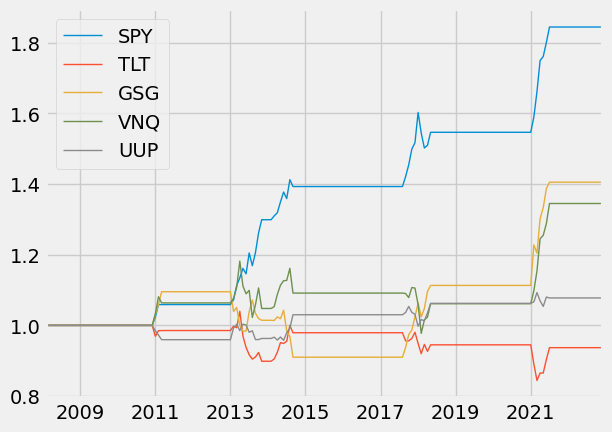

In [23]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['expansion'], axis=0)).cumprod().plot(lw=1)

In [24]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.expansion).cumprod(), freq='month').print_report()
    print()

SPY
Annualized Return: 4.19%
Annualized Volatility: 4.31%
Skewness: 1.90
Kurtosis: 6.15
Max Drawdown: -6.28%
Max Drawdown Duration: 1124 days
Annualized Sharp Ratio: 0.04
Annualized Sortino Ratio: -1.93
Annualized Calmar Ratio: 0.67
Annualized VaR: -0.03
Annualized VaR Ratio: 0.13
Annualized CVaR: -0.03
Annualized CVaR Ratio: 0.11
Annualized hit Ratio: 0.83
Annualized GtP Ratio: 1.17

TLT
Annualized Return: -0.44%
Annualized Volatility: 4.46%
Skewness: -0.97
Kurtosis: 10.10
Max Drawdown: -18.84%
Max Drawdown Duration: 3532 days
Annualized Sharp Ratio: -0.99
Annualized Sortino Ratio: -0.91
Annualized Calmar Ratio: -0.02
Annualized VaR: -0.05
Annualized VaR Ratio: -0.01
Annualized CVaR: -0.06
Annualized CVaR Ratio: -0.00
Annualized hit Ratio: 0.54
Annualized GtP Ratio: 0.75

GSG
Annualized Return: 2.31%
Annualized Volatility: 5.84%
Skewness: 1.50
Kurtosis: 12.31
Max Drawdown: -16.92%
Max Drawdown Duration: 1885 days
Annualized Sharp Ratio: -0.29
Annualized Sortino Ratio: -0.93
Annualized

### 결과
      - expansion: 고성장/성장 상승 추세/고인플레이션, 고성장/성장 하락 추세/고인플레이션
      - 경기가 피크를 찍는 국면
      - 연준은 과열을 막기 위해 긴축정책을 시행
      - 결국 경기는 점차 둔화되기 시작
      - 고성장으로 주식도 좋은 성과를 보임
      - 고성장 고인플레인션 국면 -> 원자재 주식 다음으로 좋은 성과
        - 예외: 2013년 국제원자재가격은 신흥국의 수요 둔화, 생산 호조, 달러화 강세 및 투기자금 유입 감소 등으로 전반적으로 하향 안정되는 모습
        - https://www.bok.or.kr/portal/bbs/P0000528/view.do?nttId=196279&menuNo=200434&pageIndex=

### 인플레이션 국면

In [51]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,sp500_rets,deflation,inflation,recovery,expansion
2008-02-29,-0.025842,-0.004553,0.112571,-0.031814,-0.020904,-0.025842,0.0,0.0,0.0,0.0
2008-03-31,-0.008942,0.021388,-0.009416,0.064853,-0.023965,-0.008942,0.0,0.0,0.0,0.0
2008-04-30,0.047663,-0.024863,0.081922,0.063793,0.009375,0.047662,0.0,0.0,0.0,0.0
2008-05-31,0.015116,-0.026883,0.084665,-0.002110,0.004423,0.015117,0.0,0.0,0.0,0.0
2008-06-30,-0.083576,0.026536,0.103240,-0.106153,-0.009687,-0.083576,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.040802,-0.045531,-0.029655,-0.060125,0.028985,-0.040802,0.0,1.0,0.0,0.0
2022-09-30,-0.092446,-0.082351,-0.075056,-0.128713,0.035726,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,-0.059644,0.061710,0.035051,-0.003980,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.071510,-0.011899,0.061461,-0.047286,0.055592,0.0,1.0,0.0,0.0


<AxesSubplot: >

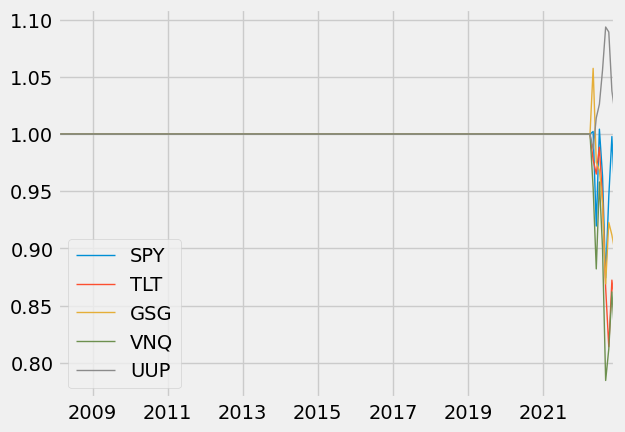

In [25]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['inflation'], axis=0)).cumprod().plot(lw=1)

In [26]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.inflation).cumprod(), freq='month').print_report()
    print()

SPY
Annualized Return: -0.41%
Annualized Volatility: 5.09%
Skewness: -0.17
Kurtosis: 29.00
Max Drawdown: -12.95%
Max Drawdown Duration: 153 days
Annualized Sharp Ratio: -0.87
Annualized Sortino Ratio: -0.82
Annualized Calmar Ratio: -0.03
Annualized VaR: -0.06
Annualized VaR Ratio: -0.00
Annualized CVaR: -0.09
Annualized CVaR Ratio: -0.00
Annualized hit Ratio: 0.50
Annualized GtP Ratio: 0.85

TLT
Annualized Return: -1.09%
Annualized Volatility: 3.61%
Skewness: -2.34
Kurtosis: 40.51
Max Drawdown: -18.59%
Max Drawdown Duration: 245 days
Annualized Sharp Ratio: -1.41
Annualized Sortino Ratio: -1.01
Annualized Calmar Ratio: -0.06
Annualized VaR: -0.05
Annualized VaR Ratio: -0.02
Annualized CVaR: -0.07
Annualized CVaR Ratio: -0.01
Annualized hit Ratio: 0.25
Annualized GtP Ratio: 1.15

GSG
Annualized Return: -0.73%
Annualized Volatility: 3.68%
Skewness: -2.20
Kurtosis: 39.56
Max Drawdown: -17.81%
Max Drawdown Duration: 214 days
Annualized Sharp Ratio: -1.29
Annualized Sortino Ratio: -1.03
Ann

In [27]:
ma_regime_df[ma_regime_df.inflation != 0]

,SPY,TLT,GSG,VNQ,UUP,sp500_rets,deflation,inflation,recovery,expansion
2022-05-31,0.002257,-0.022533,0.057432,-0.046854,-0.013058,0.002257,0.0,1.0,0.0,0.0
2022-06-30,-0.082460,-0.012745,-0.077476,-0.074489,0.027563,-0.082460,0.0,1.0,0.0,0.0
2022-07-31,0.092087,0.024310,-0.007359,0.086160,0.011803,0.092087,0.0,1.0,0.0,0.0
2022-08-31,-0.040802,-0.045531,-0.029655,-0.060125,0.028985,-0.040802,0.0,1.0,0.0,0.0
2022-09-30,-0.092446,-0.082351,-0.075056,-0.128713,0.035726,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,-0.059644,0.061710,0.035051,-0.003980,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.071510,-0.011899,0.061461,-0.047286,0.055592,0.0,1.0,0.0,0.0
2022-12-31,-0.057628,-0.026200,-0.016674,-0.050343,-0.019407,-0.057628,0.0,1.0,0.0,0.0


In [28]:
ma_regime_df.inflation.iloc[-8:]
ma_regime_df.iloc[-8:]

,SPY,TLT,GSG,VNQ,UUP,sp500_rets,deflation,inflation,recovery,expansion
2022-05-31,0.002257,-0.022533,0.057432,-0.046854,-0.013058,0.002257,0.0,1.0,0.0,0.0
2022-06-30,-0.082460,-0.012745,-0.077476,-0.074489,0.027563,-0.082460,0.0,1.0,0.0,0.0
2022-07-31,0.092087,0.024310,-0.007359,0.086160,0.011803,0.092087,0.0,1.0,0.0,0.0
2022-08-31,-0.040802,-0.045531,-0.029655,-0.060125,0.028985,-0.040802,0.0,1.0,0.0,0.0
2022-09-30,-0.092446,-0.082351,-0.075056,-0.128713,0.035726,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,-0.059644,0.061710,0.035051,-0.003980,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.071510,-0.011899,0.061461,-0.047286,0.055592,0.0,1.0,0.0,0.0
2022-12-31,-0.057628,-0.026200,-0.016674,-0.050343,-0.019407,-0.057628,0.0,1.0,0.0,0.0


### 결과
    - inflation: 저성장/성장 하락 추세/고인플레이션
    - 높은 인플레이션 유지되고 있지만 성장이 둔화 또는 침체되는 국면
    - 연준은 높은 인플레이션을 제어하기 위해 공적적으로 기준금리를 인상하게 되고 경기 둔화 폭이 확대
    - 높은 인플레이션으로 인해 원자재 가격이 일시적으로 크게 상승할 수 있지만 경기 둔화로 인한 수요 감소 폭이 커질 경우 급격한 조정을 받는다.
    - 달러 인덱스만 수익 발생 -> 회복기에서 상승, 후퇴기에 하락, 위축기에 상승. 하지만 달러는 안전자산의 역할도 하기 때문에 경제 위축기에 상승하는 모습을 보이기도 한다.  

### 위축국면

<AxesSubplot: >

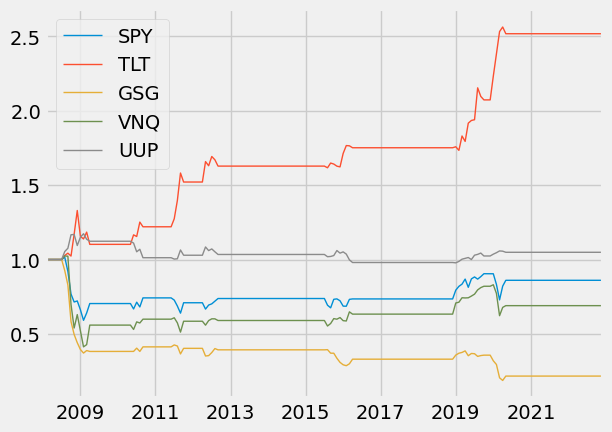

In [29]:
(1+ma_regime_df[multi_asset_tickers].mul(ma_regime_df['deflation'], axis=0)).cumprod().plot(lw=1)

In [30]:
for ticker in multi_asset_tickers:
    print(ticker)
    Metric(portfolio=(1 + ma_regime_df[ticker] * ma_regime_df.deflation).cumprod(), freq='month').print_report()
    print()

SPY
Annualized Return: -1.00%
Annualized Volatility: 11.60%
Skewness: -0.50
Kurtosis: 7.04
Max Drawdown: -41.80%
Max Drawdown Duration: 5235 days
Annualized Sharp Ratio: -0.43
Annualized Sortino Ratio: -0.37
Annualized Calmar Ratio: -0.02
Annualized VaR: -0.11
Annualized VaR Ratio: -0.00
Annualized CVaR: -0.15
Annualized CVaR Ratio: -0.00
Annualized hit Ratio: 0.54
Annualized GtP Ratio: 0.81

TLT
Annualized Return: 6.39%
Annualized Volatility: 10.12%
Skewness: 1.88
Kurtosis: 10.28
Max Drawdown: -17.13%
Max Drawdown Duration: 1248 days
Annualized Sharp Ratio: 0.24
Annualized Sortino Ratio: -0.65
Annualized Calmar Ratio: 0.37
Annualized VaR: -0.05
Annualized VaR Ratio: 0.12
Annualized CVaR: -0.10
Annualized CVaR Ratio: 0.06
Annualized hit Ratio: 0.54
Annualized GtP Ratio: 2.58

GSG
Annualized Return: -9.76%
Annualized Volatility: 16.64%
Skewness: -2.74
Kurtosis: 16.03
Max Drawdown: -81.33%
Max Drawdown Duration: 5266 days
Annualized Sharp Ratio: -0.83
Annualized Sortino Ratio: -0.31
Annu

### 결과
    - deflation: 저성장/성장 하락 추세/저인플레이션
    - 성장과 인플레이션이 모두 낮게 유지되는 국면
    - 위축 국면이 길어질수록 급격한 수요 감소와 디레버리징이 나타나게 되고 경기침체가 발생
    - 모든 위험 자산 가격이 크게 하락
    - 안전사잔인 장기채권과 달러가 가장 좋은 성과를 보임

### 종합
    - 회복국면
      - buy 주식, 부동산
      - sell 장기채권
    - 과열국면
      - buy 주식, 원자재
      - sell 장기 채권
    - 인플레이션
      - buy 달러
      - sell 주식
    - 위축국면
      - buy 장기채권
      - sell 주식, 부동산, 원자재
    
    - 추가 인사이트
      - 원자재는 거시경제의 영향과 수요와 공급(미시경제)의 영향 역시 많이 받는다. 
      -> 신문,기사 등의 영향을 추가하기 위해 NLP 사용해볼 수 있듯  

### 마지막으로 각 국면별 성과가 가장 좋은 자산군에 투자한다고 가정하고 백테스트 진행해보자

In [31]:
ma_regime_df

,SPY,TLT,GSG,VNQ,UUP,sp500_rets,deflation,inflation,recovery,expansion
2008-02-29,-0.025842,-0.004553,0.112571,-0.031814,-0.020904,-0.025842,0.0,0.0,0.0,0.0
2008-03-31,-0.008942,0.021388,-0.009416,0.064853,-0.023965,-0.008942,0.0,0.0,0.0,0.0
2008-04-30,0.047663,-0.024863,0.081922,0.063793,0.009375,0.047662,0.0,0.0,0.0,0.0
2008-05-31,0.015116,-0.026883,0.084665,-0.002110,0.004423,0.015117,0.0,0.0,0.0,0.0
2008-06-30,-0.083576,0.026536,0.103240,-0.106153,-0.009687,-0.083576,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.040802,-0.045531,-0.029655,-0.060125,0.028985,-0.040802,0.0,1.0,0.0,0.0
2022-09-30,-0.092446,-0.082351,-0.075056,-0.128713,0.035726,-0.092446,0.0,1.0,0.0,0.0
2022-10-31,0.081276,-0.059644,0.061710,0.035051,-0.003980,0.081276,0.0,1.0,0.0,0.0
2022-11-30,0.055592,0.071510,-0.011899,0.061461,-0.047286,0.055592,0.0,1.0,0.0,0.0


<AxesSubplot: >

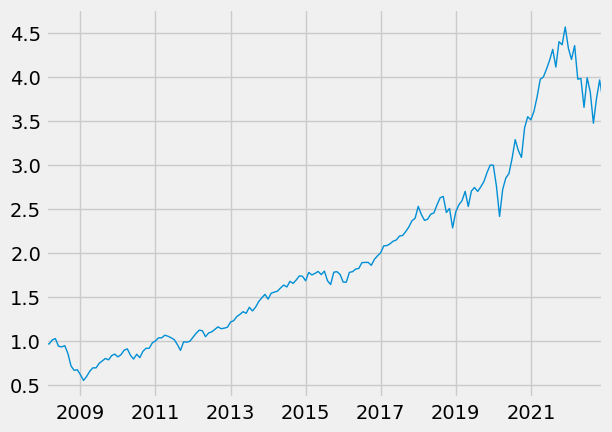

In [32]:
(1 + ma_regime_df['SPY']).cumprod().plot(lw=1)

In [33]:
Metric(portfolio=(1 + ma_regime_df['SPY']).cumprod(), freq='month').print_report()

Annualized Return: 9.43%
Annualized Volatility: 16.21%
Skewness: -0.61
Kurtosis: 0.95
Max Drawdown: -46.32%
Max Drawdown Duration: 975 days
Annualized Sharp Ratio: 0.34
Annualized Sortino Ratio: -0.21
Annualized Calmar Ratio: 0.20
Annualized VaR: -0.11
Annualized VaR Ratio: 0.08
Annualized CVaR: -0.15
Annualized CVaR Ratio: 0.06
Annualized hit Ratio: 0.67
Annualized GtP Ratio: 0.81


In [34]:
print(len(ma_regime_df.loc[(ma_regime_df.recovery == 1)]['SPY']))
print(len(ma_regime_df.loc[(ma_regime_df.expansion == 1)]['SPY']))
print(len(ma_regime_df.loc[(ma_regime_df.deflation == 1)]['TLT']))
print(len(ma_regime_df.loc[(ma_regime_df.inflation == 1)]['UUP']))

52
35
46
8


In [35]:
best_regime = pd.concat([
                        ma_regime_df.loc[(ma_regime_df.recovery == 1)]['SPY'], 
                        ma_regime_df.loc[(ma_regime_df.expansion == 1)]['SPY'],
                        ma_regime_df.loc[(ma_regime_df.deflation == 1)]['TLT'],
                        ma_regime_df.loc[(ma_regime_df.inflation == 1)]['UUP'],
                        ], ignore_index=False, axis=0)

best_regime

2009-05-31    0.058453
2009-06-30   -0.000655
2009-07-31    0.074605
2009-08-31    0.036940
2009-09-30    0.035458
                ...   
2022-08-31    0.028985
2022-09-30    0.035726
2022-10-31   -0.003980
2022-11-30   -0.047286
2022-12-31   -0.019407
Length: 141, dtype: float64

In [36]:
type(best_regime.index)
type(ma_regime_df.index)

best_regime.index = pd.to_datetime(best_regime.index)
best_regime.index

DatetimeIndex(['2009-05-31', '2009-06-30', '2009-07-31', '2009-08-31',
               '2009-09-30', '2009-10-31', '2009-11-30', '2009-12-31',
               '2010-01-31', '2010-02-28',
               ...
               '2020-04-30', '2020-05-31', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=141, freq=None)

In [37]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained

DatetimeIndex(['2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31',
               '2008-06-30', '2008-07-31', '2011-04-30', '2011-05-31',
               '2011-06-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31', '2022-01-31', '2022-02-28',
               '2022-03-31', '2022-04-30'],
              dtype='datetime64[ns]', freq=None)

In [38]:
not_explained = ma_regime_df.index.difference(best_regime.index)
not_explained_df = pd.Series({'port_val':0}, index=not_explained)

In [39]:
total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)

/var/folders/6m/p0mfz7q566zcnpddq0xg_r740000gn/T/ipykernel_56628/2470937050.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_regime = best_regime.append(not_explained_df).sort_index().fillna(0)


<AxesSubplot: >

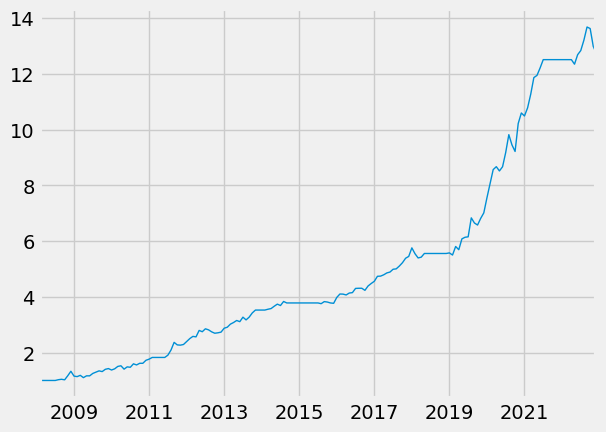

In [40]:
(1 + total_regime).cumprod().plot(lw=1)

In [41]:
Metric(portfolio=(1 + total_regime).cumprod(), freq='month').print_report()

Annualized Return: 18.60%
Annualized Volatility: 12.41%
Skewness: 0.53
Kurtosis: 2.98
Max Drawdown: -17.13%
Max Drawdown Duration: 487 days
Annualized Sharp Ratio: 1.18
Annualized Sortino Ratio: -0.39
Annualized Calmar Ratio: 1.09
Annualized VaR: -0.07
Annualized VaR Ratio: 0.21
Annualized CVaR: -0.11
Annualized CVaR Ratio: 0.14
Annualized hit Ratio: 0.70
Annualized GtP Ratio: 1.63


### 결론 
- 단순 지수 투자보다 시황을 반영하는 것이 투자 성과를 개선
- 각 시황마다 지수들은 상이한 움직임을 보이고 이를 활용해 투자하는 것은 중요하다